In [1]:
import sys
sys.path.append('./src/')
import os
os.chdir("../")

In [2]:
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import encode_labels


In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
config_file = "config.json"
with open(config_file, 'r') as f:
    config = json.load(f)

In [6]:
model_path = "./models/model_bst.pkl"
model, class_names = joblib.load(model_path)
class_map= {class_names[i]:i for i in range(len(class_names))}
class_map


{'constant': 0, 'multi': 1, 'normal': 2, 'rapid': 3}

In [7]:
test_data_path = config['processed_test_data_path']
df_test = pd.read_csv(test_data_path)
y0_test = df_test['cluster']
X_test = df_test.drop(columns={'cluster','well'})
y_test, _ = encode_labels(y0_test)
y_test_pred = model.predict(X_test)
y_test_pred

array([0, 0, 0, ..., 2, 2, 2])

In [8]:
norm_conf_mx = confusion_matrix(y_test, y_test_pred,normalize='true')
norm_conf_mx

array([[0.53125   , 0.0625    , 0.40625   , 0.        ],
       [0.25      , 0.1875    , 0.4375    , 0.125     ],
       [0.46666667, 0.16666667, 0.36666667, 0.        ],
       [0.36363636, 0.09090909, 0.36363636, 0.18181818]])

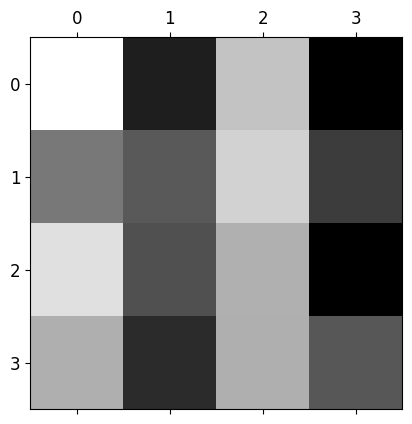

In [9]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* The column of class 2 is bright, which tells you that many samples get misclassified as 2s. 
* 
* sample 2 is confused with sample 0 
* Sample 3 is all over the place, it gets confused with 0, 1, and mostly with  2.
* never, anyclass is confused as sample 3

**How can we reduce the false 2s?**

In [10]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 0")
)


,well,y,p
18605,well_126,0,0
18606,well_126,0,0
18607,well_126,0,0
18608,well_126,0,0
18609,well_126,0,0
...,...,...,...
323722,well_87,0,0
323723,well_87,0,0
323724,well_87,0,0
323725,well_87,0,0


In [11]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 2")
)


,well,y,p
33489,well_142,0,2
33490,well_142,0,2
33491,well_142,0,2
33492,well_142,0,2
33493,well_142,0,2
...,...,...,...
293954,well_571,0,2
293955,well_571,0,2
293956,well_571,0,2
293957,well_571,0,2


In [12]:
well_id = 'well_120'
df_well = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
 .groupby('well')
 .get_group(well_id)
 .sort_values(['date'])
 #.filter(['date','value'])
 .set_index('date')
)
df_well.head()

,well,value,cluster
date,,,
1977-03-01,well_120,1.771429,constant
1977-04-01,well_120,1.843750,constant
1977-05-01,well_120,0.481928,constant
1977-06-01,well_120,0.000000,constant
1977-07-01,well_120,0.717949,constant


In [13]:
well_cluster = df_well['cluster'].iloc[0]
well_cluster

'constant'

In [14]:
df_well_Y = df_well[["value"]].resample('Y').mean()
df_well_Y.head()

,value
date,
1977-12-31,0.814464
1978-12-31,0.848213
1979-12-31,1.002060
1980-12-31,2.366487
1981-12-31,1.911037


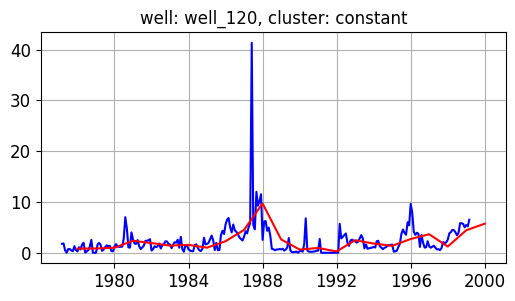

In [15]:
plt.figure(figsize=(6,3))
plt.plot(df_well.index, df_well.value,color='blue')
plt.title(f'well: {well_id}, cluster: {well_cluster}')
plt.grid(True)
plt.plot(df_well_Y.index, df_well_Y.value,color='red')
plt.show()

In [16]:
wells_00 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p==0")
 .well
 .to_list()
)
wells_01 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p==1")
 .well
 .to_list()
)
wells_10 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 1 and p==0")
 .well
 .to_list()
)
wells_11 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 1 and p==1")
 .well
 .to_list()
)
len(wells_00), len(wells_01), len(wells_10), len(wells_11)


(63257, 7442, 14884, 11163)

In [17]:
df_00 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_00]
)
df_01 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_01]
)
df_10 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_10]
)
df_11 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_11]
)


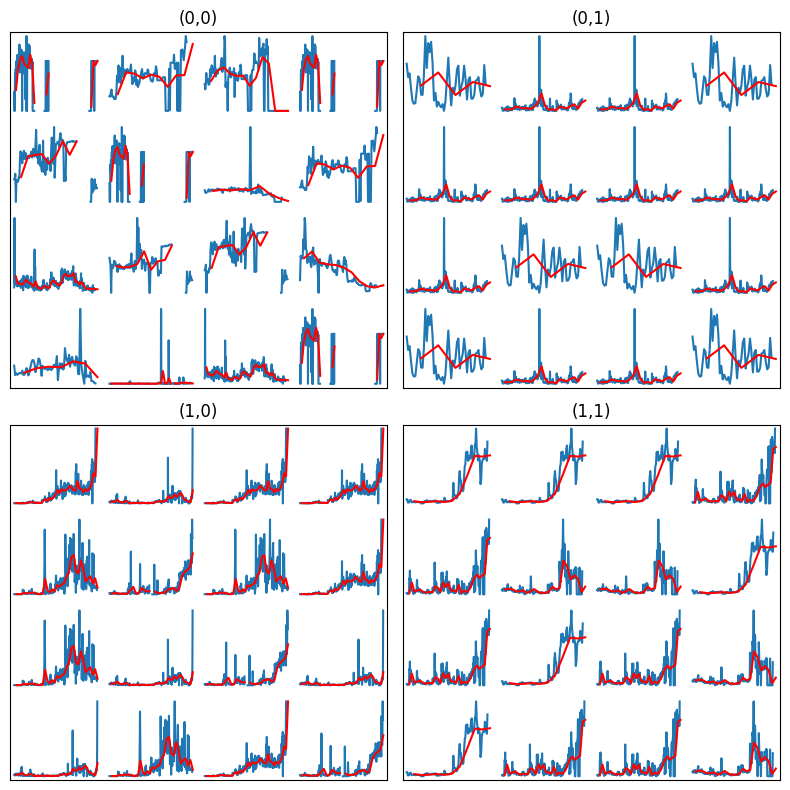

In [27]:
def plot_timeseries(df,big_ax,nrows=4,ncols=4,title=''):
    inner_grid = big_ax.get_subplotspec().subgridspec(nrows, ncols)
    axes = inner_grid.subplots().flatten()
    num_rows = df.shape[0]
    for i,(index,row) in enumerate(df.iterrows()):
        ax = axes[i]  
        ax.plot(row)  
        ax.plot(row.resample('Y').mean(),color = 'red')  
        ax.axis('off')

    for i in range(num_rows, nrows*ncols):
        ax = axes[i]
        ax.axis('off')
    big_ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    big_ax.set_title(title)


fig = plt.figure(figsize=(8, 8))
big_ax = plt.subplot(221); plot_timeseries(df_00.sample(16),big_ax,title = '(0,0)')
big_ax = plt.subplot(222); plot_timeseries(df_01.sample(16),big_ax,title = '(0,1)')  
big_ax = plt.subplot(223); plot_timeseries(df_10.sample(16),big_ax,title = '(1,0)')  
big_ax = plt.subplot(224); plot_timeseries(df_11.sample(16),big_ax,title = '(1,1)') 
plt.tight_layout()
plt.show()